# CNN on timeseries data
## Yoav Ram

Here, we apply convolutional neural networks to timeseries data rather than image data. 
I follow an example [Keras docs](https://keras.io/examples/timeseries/timeseries_classification_from_scratch/), but avoid looking at it before you try to solve it yourself.

You can find more details on CNNs for timeseries classification in [Wang et al. 2016](https://arxiv.org/abs/1611.06455).

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import jax
import keras
print('Keras:', keras.__version__, 'backend:', keras.backend.backend(), jax.default_backend())

Keras: 3.8.0 backend: jax cpu


# The FordA dataset

The dataset we are using here is called [_FordA_](http://www.j-wichard.de/publications/FordPaper.pdf).
The dataset contains 3,601 training instances and another 1,320 testing instances. So it's not a very big dataset.

Each timeseries corresponds to a measurement of engine noise captured by a motor sensor. 
The goal is to detect the presence of a specific issue with the engine. It is a balanced binary classification task. 

We will use the `FordA_TRAIN` file for training and the `FordA_TEST` file for testing. 
The first column corresponds to the label.

In [7]:
train_data = np.loadtxt('../data/FordA_TRAIN.tsv', delimiter="\t")
x_train, y_train = train_data[:, 1:], train_data[:, 0].astype(int)
test_data = np.loadtxt('../data/FordA_TEST.tsv', delimiter="\t")
x_test, y_test = train_data[:, 1:], train_data[:, 0].astype(int)

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
timeseries_length = x_train.shape[1]
print("Good: {}, Bad: {}".format((y_train[:,0]==1).sum(), (y_train[:,0]==0).sum()))
print("Timeseries length:", timeseries_length)

Good: 1846, Bad: 1755
Timeseries length: 500


Here we visualize five example for each class in the dataset.

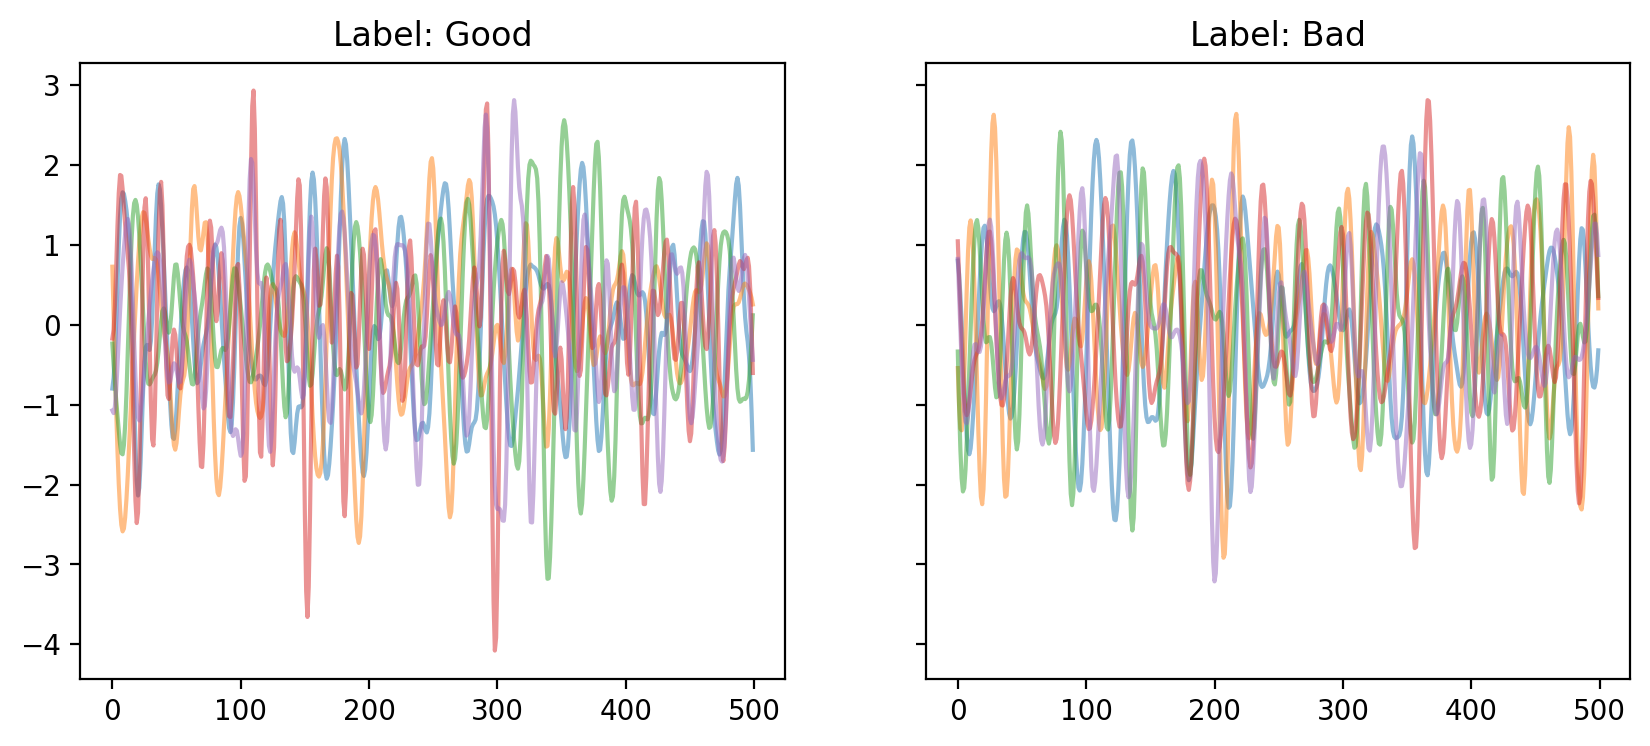

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

x_ = x_train[y_train[:,0]==1]
axes[0].plot(x_[:5].T, alpha=0.5)
axes[0].set_title("Label: Good")

x_ = x_train[y_train[:,1]==1]
axes[1].plot(x_[:5].T, alpha=0.5)
axes[1].set_title("Label: Bad");

We can see that it is not easy to discriminate visually between "good" and "bad" examples.

Note: the data is already scaled (or z-normalized): each timeseries sample has a mean equal to zero and a standard deviation equal to one. This type of normalization is very common for timeseries classification problems, see [Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

# CNN classifier

Let's build a CNN classifier like those we have seen before for images.
But this time, it will be applied to time series data.
Note that this means the convolutions are one- rather than two-dimensional.
But you still need to reshape the input to have the last "channel" dimenion.

Also note that the labels (`y_train` and `y_test`) are one-hot encoded, despite having only two classes. So either remove one of the columns in the label arrays, or use an output layer with 2 units--I used the latter.

In [9]:
model = keras.Sequential([
    keras.Input((timeseries_length,)),
    keras.layers.Reshape((timeseries_length, 1)),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.Conv1D(filters=64, kernel_size=3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 500, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 500, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 500, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 500, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,858 (101.01 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 384 (1.50 KB)

In [10]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=["accuracy"],
)

Let's run the training. 
I suggest you use use two "callbacks":
- `ReduceLROnPlateau` reduces the learning rate when the validation loss does not decrease for 20 epochs (validation loss is computed on 20% of the training data). You can see it first decreasing on epoch 120 below.
- `EarlyStopping` stops the training when the validation loss does not decrease for 50 epochs.

In [11]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1, restore_best_weights=True),
    ]
)

Epoch 1/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.6528 - loss: 0.5870 - val_accuracy: 0.4743 - val_loss: 0.7272 - learning_rate: 0.0010
Epoch 2/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.7680 - loss: 0.4693 - val_accuracy: 0.4743 - val_loss: 0.6976 - learning_rate: 0.0010
Epoch 3/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7763 - loss: 0.4451 - val_accuracy: 0.5257 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 4/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7969 - loss: 0.4151 - val_accuracy: 0.5257 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 5/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7994 - loss: 0.3977 - val_accuracy: 0.5257 - val_loss: 0.8628 - learning_rate: 0.0010
Epoch 6/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.7961 - loss: 0.3931 - val_accuracy: 0.5312 - val_loss: 0.9789 - learning_rate: 0.0010
Epoch 7/300
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8125 - loss: 0.3856 - 

In [13]:
model.save("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "wb") as f:
    pickle.dump(history, f)

In [ ]:
model = keras.models.load_model("../data/ford_cnn.keras")
with open("../data/ford_cnn_history.p", "rb") as f:
    history = pickle.load(f)

Let's see how the CNN model performs on the test data.

In [14]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9848 - loss: 0.0519
Test accuracy 0.9786170721054077
Test loss 0.06501291692256927


I reached a high test accuracy - 98%.
You can see that only in the last few epochs the validation accuracy stabilized.

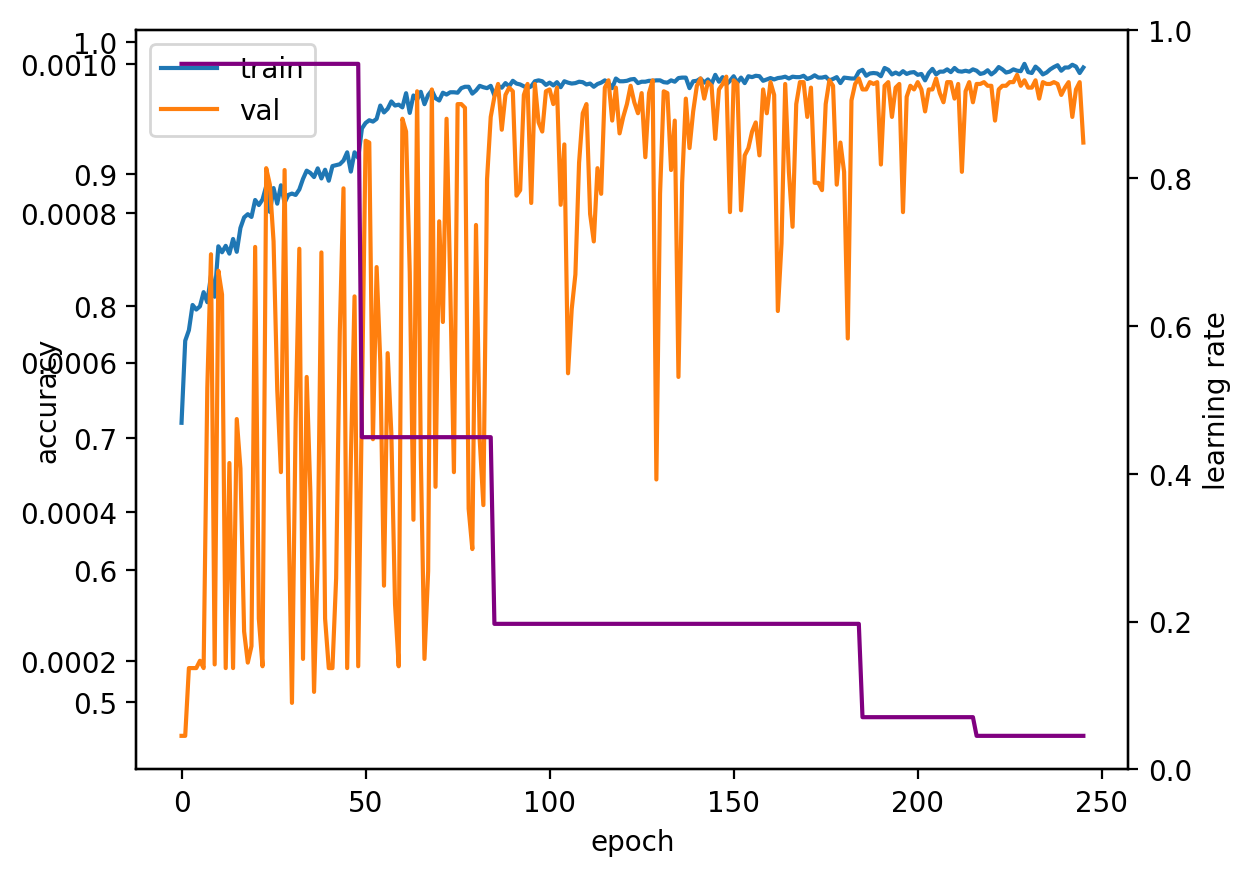

In [37]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"]);
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(np.array(history.history['learning_rate']), color='purple')
ax2.twinx().set_ylabel('learning rate');

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)